In [7]:
import os
import torch
from collections import defaultdict
import torchvision
import pickle
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
from scripts.utils import *
import ast
from attribution_certification.certifier.utils import *
font = {'family': 'serif', 'weight': 'normal', 'size': 16}
matplotlib.rc('font', **font)

# 1. Load Certified Attributions

In [3]:
input_dir = 'outputs/certified'

# Define a recursive defaultdict for nested dict creation
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)

graph_dict = recursive_defaultdict()
xai_methods = set()
for filename in os.listdir(input_dir):
    if not filename.endswith('.pt'):
        continue  # Skip non-tensor files
    try:
        name = os.path.splitext(filename)[0]
        dtype, sigma, layer, xai_method, model, Ks, n, tau, _ = name.split('_')
        tensor = torch.load(os.path.join(input_dir, filename))
        graph_dict[f'sigma_{sigma}'][layer][xai_method][Ks][int(n)][float(tau)] = {'certified': tensor.cpu().numpy()}
        xai_methods.add(xai_method)  # <-- collect method names here
    except Exception as e:
        print(f"Skipping {filename}: {e}")
xai_methods = list(xai_methods)

# 2. Load ImageNet

In [4]:
def load_dataset(dataset_dir, max_images=200):
    test_data_dict = torch.load(os.path.join(dataset_dir, 'test.pt'))
    scale = test_data_dict["scale"]
    img_dims = test_data_dict["input_dims"][1:]
    imagenet_inv_normalize_transform = torchvision.transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    shuffled_idx = pickle.load(open('data/images_indices.pkl', 'rb'))
    images = imagenet_inv_normalize_transform(test_data_dict["data"][shuffled_idx][:max_images])
    return images, img_dims, scale

dataset_dir = 'data/imagenet'
images, img_dims, scale = load_dataset(dataset_dir, max_images=100)

# 3. Plot Certified Attributions

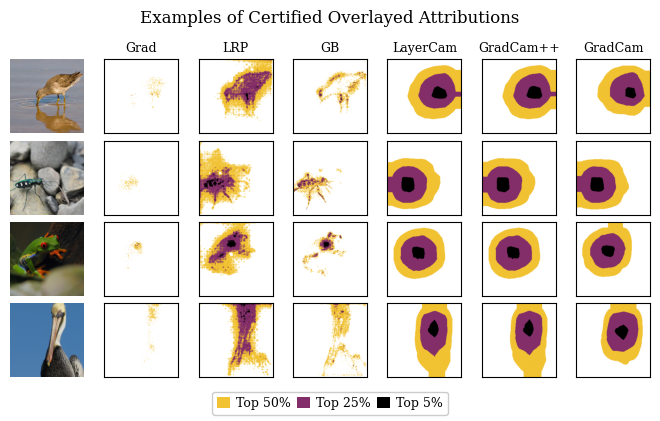

In [19]:

os.makedirs('images', exist_ok=True)

# Demo values
image_indices = [74, 41, 42, 16] # picked indices for demo
n, tau, sigma = 100, 0.75, 'sigma_0.15'
if isinstance(Ks, str):
    Ks = ast.literal_eval(Ks)
fontsize = 12
idx_dict = {x: i for i, x in enumerate(image_indices)}
num_images = len(image_indices) 
rows_per_image = 1
methods_per_row = len(xai_methods)
methods_layout = [xai_methods[i:i + methods_per_row] for i in range(0, len(xai_methods), methods_per_row)]
col_types = ['overlayed']
layers = ['Input']
features = len(col_types)*len(layers)
num_rows = num_images*rows_per_image*len(methods_layout)
num_cols = 1 + methods_per_row*features

fig, axes = plt.subplots(nrows=num_rows, 
                         ncols=num_cols, figsize=(num_cols, num_rows))
axes = axes.reshape(num_rows, num_cols)
for ax in axes.flatten():
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for i in range(num_rows):
    axes[i, 0].axis('off')
    
greens = plt.cm.Greens
custom_greens = LinearSegmentedColormap.from_list("custom_greens", [(1, 1, 1)] + [greens(i) for i in range(greens.N)], N=greens.N)
anchor_rgba = [matplotlib.colors.to_rgba(c) for c in anchor_hex_colors]
custom_cmap = LinearSegmentedColormap.from_list("custom_anchor_map", anchor_rgba)
color_list = [custom_cmap(i / max(len(Ks)-1, 1)) for i in range(len(Ks))]
inferno_custom = ListedColormap(color_list, name="inferno_custom")
colors = {'abstain': (0.85, 0.85, 0.85, 1), 'bg': (1, 1, 1, 1), 'greens': custom_greens, 'inferno': inferno_custom, 'inferno_ls': color_list}



for layer_idx, layer in enumerate(layers):
    for super_row_idx, xai_subset in enumerate(methods_layout):
        for xai_idx, xai_method in enumerate(xai_subset):
            if 'Cam' in xai_method: layer='Final'
            else: layer = 'Input'
            for idx, im_idx in enumerate(image_indices):
                row_idx = idx*(rows_per_image*len(methods_layout)) + super_row_idx*rows_per_image
                image = images[im_idx].cpu().numpy().transpose(1, 2, 0)
                axes[idx*rows_per_image*len(methods_layout), 0].imshow(image)
                degree = 0
                for col_i, col_type in enumerate(col_types):
                    col_idx = layer_idx*features + xai_idx*len(col_types) + col_i + 1
                    ax = axes[row_idx, col_idx]

                    if col_type == 'overlayed':

                        certified_all = graph_dict[sigma][layer][xai_method][str(Ks)][n][tau]['certified'][im_idx].squeeze()
                        rgb_certified = get_certified_rgb(certified_all, 
                                        cmap=colors['inferno'], 
                                        degrees=[[K] for K in Ks], 
                                        abstain_color = colors['abstain'], 
                                        certified_0_color=colors['bg'])
                        ax.imshow(rgb_certified)
                        if row_idx == 0:
                            ax.set_title(xai_method.replace('PlusPlus', '++'), fontsize=fontsize-3)

plt.tight_layout(rect=[0, 0, 1, 1])  
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Fine-tune spacing


legend_elements = [mpatches.Patch(facecolor=c, label=f'Top {K}%') for c, K in zip(color_list, Ks)]

fig.legend(handles=legend_elements, loc='lower center', bbox_transform=fig.transFigure, ncol=(len(Ks) + 2), frameon=True,
            columnspacing=0.5, handletextpad=0.5, 
        labelspacing=0.5, fontsize=fontsize - 3, framealpha=1,
        handlelength=1.0, handleheight=1.0)
plt.subplots_adjust(bottom=0.1)  # leaves space for the legend
fig.suptitle("Examples of Certified Overlayed Attributions", fontsize=fontsize, y=1.02)
plt.savefig('images/demo.png', dpi=200, bbox_inches='tight')
plt.show()